In [1]:
import json
from graph_construction.qp.visitor.UtilVisitor import LiteralChecker
path = "/data/wikidata_0_1_10_v3_path_weight_loss/queryplans"
qp_name= "lsqQuery-zzMtZRU4sBFKtI6Kp2XNZUag6EOgnbgVjfwbMo8atjc"
qp = json.load(open(f"{path}/{qp_name}", "r"))

In [2]:
qp

{'opName': 'project',
 'subOp': [{'opName': 'BGP',
   'subOp': [{'Subject': '?var1',
     'Predicate': 'http://www.wikidata.org/prop/direct/P3203',
     'Object': {'value': '101860',
      'datatype': 'http://www.w3.org/2001/XMLSchema#string',
      'langTag': ''},
     'opName': 'Triple'}]}]}

In [38]:
class AbstractVisitor:
    def visitBGP(self, input):
        pass
    def visitTriple(self, input):
        pass
    def visitFilter(self, input):
        pass
    def visitOptional(self, input):
        pass
    def visitDefault(self, input):
        for op in input['subOp']:
            dispatch(op,self)
    def visitDisjunction(self, input):
        pass
    def visitJoin(self, input):
        pass
class PrintVisitor(AbstractVisitor):
    def visitBGP(self, input):
        print("starting ", input['opName'])
        for e in input['subOp']:
            dispatch(e, self)
        print("ending ", input['opName'])
        
    def visitTriple(self,input):
        print("starting ", input['opName'])
        print(input)
        print("ending ", input['opName'])
        
    def visitFilter(self, input):
        print("starting ", input['opName'])
        print("expression ", input['expr'])
        for o in input['subOp']:
            dispatch(o, self)
        print("ending ", input['opName'])
        
    def visitOptional(self, input):
        print("starting ", input['opName'])
        for o in input['subOp']:
            dispatch(o, self)
        print("ending ", input['opName'])
    def visitDisjunction(self, input):
        print("starting ", input['opName'])
        for o in input['subOp']:
            dispatch(o, self)
        print("ending ", input['opName'])
    
    def visitJoin(self, input):
        print("starting ", input['opName'])
        for o in input['subOp']:
            dispatch(o, self)
        print("ending ", input['opName'])
        
class DefaultVisitor(AbstractVisitor):
    def visitBGP(self, input):
        for e in input['subOp']:
            dispatch(e, self)
        
    def visitTriple(self,input):
        pass
    def visitTriplePath(self,input):
        pass

    def visitExpr(self, input):
        pass
        
    def visitFilter(self, input):
        self.visitExpr(input['expr'])
        for o in input['subOp']:
            dispatch(o, self)
        
    def visitOptional(self, input):
        for o in input['subOp']:
            dispatch(o, self)
            
    def visitDisjunction(self, input):
        for o in input['subOp']:
            dispatch(o, self)
    
    def visitJoin(self, input):
        for o in input['subOp']:
            dispatch(o, self)
        
def dispatch(input, visitor):
    match input['opName']:
        case "project":
            for op in input['subOp']:
                dispatch(op,visitor)
        case "BGP":
            visitor.visitBGP(input)
        case "Triple":
            visitor.visitTriple(input)
        case "path":
            visitor.visitTriplePath(input)
        case "sequence":
            for op in input['subOp']:
                dispatch(op,visitor)
        case "filter":
            visitor.visitFilter(input)
        case "conditional":
            visitor.visitOptional(input)
        case "leftjoin":
            visitor.visitOptional(input)
        case "extend":
            for op in input['subOp']:
                dispatch(op,visitor)
        case "group":
            for op in input['subOp']:
                dispatch(op,visitor)
        case "distinct":
            for op in input['subOp']:
                dispatch(op,visitor)
        case "table":
            for op in input['subOp']:
                dispatch(op,visitor)
        case "assign":
            visitor.visitDefault(input)
        case "disjunction":
            visitor.visitDisjunction(input)
        case "join":
            visitor.visitJoin(input)
        case "reduced":
            visitor.visitDefault(input)
        case "service":
            visitor.visitDefault(input)
        case "graph":
            visitor.visitDefault(input)
        case _:
            raise Exception(f"unsupported {input['opName']}\n{input}")
visitor = PrintVisitor()
dispatch(qp, visitor)

starting  BGP
starting  Triple
{'Subject': '?var1', 'Predicate': 'http://www.wikidata.org/prop/direct/P3203', 'Object': {'value': '101860', 'datatype': 'http://www.w3.org/2001/XMLSchema#string', 'langTag': ''}, 'opName': 'Triple'}
ending  Triple
ending  BGP


In [4]:
class JoinChecker(DefaultVisitor):
    def visitJoin(self, input):
        print(len(input['subOp']))
        print(input['subOp'][0])
        print('\n\n\n')
        print(input['subOp'][1])
        #for o in input['subOp']:
        #    dispatch(o, self)
        raise Exception()
        
class LiteralChecker(DefaultVisitor):
    def __init__(self):
        self.laTags = list()
        self.datatypes = list()
        
    def visitTriple(self,input):
        if 'datatype' in input['Object'].keys():
            self.datatypes.append(input['Object']['datatype'])
        if 'langTag' in input['Object'].keys():
            self.laTags.append(input['Object']['langTag'])

In [42]:
import pandas as pd
import os
def get_files(path):
    df = pd.read_csv(f'{path}/train_sampled.tsv', sep='\t')
    train_ids = list(df['id'].apply(lambda x : x[20:]))
    df = pd.read_csv(f'{path}/val_sampled.tsv', sep='\t')
    val_ids = list(df['id'].apply(lambda x : x[20:]))
    df = pd.read_csv(f'{path}/test_sampled.tsv', sep='\t')
    test_ids = list(df['id'].apply(lambda x : x[20:]))
    qp_path = f'{path}/queryplans'
    train_files = [f"{qp_path}/{x}" for x in os.listdir(qp_path) if not '.' in x and x in train_ids]
    val_files = [f"{qp_path}/{x}" for x in os.listdir(qp_path) if not '.' in x and x in val_ids]
    test_files = [f"{qp_path}/{x}" for x in os.listdir(qp_path) if not '.' in x and x in test_ids]
    return train_files, val_files, test_files
train_f, val_f, test_f = get_files('/data/wikidata_0_1_10_v3_path_weight_loss')

In [43]:
len(train_f), len(val_f), len(test_f)

(18755, 6250, 6252)

In [7]:
df['id'].apply(lambda x : x[20:])

0                                                       88
1        lsqQuery-uFC3wDkLQrVsjB5TnJggZPUv-3SKDLPlN7UxG...
2        lsqQuery-SuRpVwsIGtWuNn-SlmaA_oAcp5mej6U1yrG64...
3                                  additionalWikidata20157
4        lsqQuery-RRxMsjIJF_8TrHdSbdkUXEBz1-UgIIwinZQEn...
                               ...                        
18750    lsqQuery-hTeQMAS9RKi5jOjYSTvZe7BWT8K-60-GNaOut...
18751                   additionalWikidata108471zeroOrMore
18752                             additionalWikidata119034
18753    lsqQuery-NHgW8QPt_S-WPJwbMhvQStz5vGEZTYkbhWVme...
18754    lsqQuery-5BQjw8gt9opVsct7kEnPDt48u5NuYnNTwam9J...
Name: id, Length: 18755, dtype: object

In [44]:
import json5
class DatExtractor(DefaultVisitor):
    def __init__(self):
        self.preds = list()
        self.ents = list()
        
    def visitTriple(self,input):
        if 'http' in input['Predicate']:
            self.preds.append(input['Predicate'])
        if 'http' in input['Subject']:
            self.ents.append(input['Subject'])
        if 'http' in  input['Object']['value']:
            self.ents.append(input['Object']['value'])
    def visitPath(self,input):
        if 'Predicates' in input.keys() and 'http' in input['Predicates'][0]:
            self.preds.append(input['Predicates'][0])
        if 'http' in  input['Subject']:
            self.ents.append(input['Subject'])
        if 'http' in  input['Object']['value']:
            self.ents.append(input['Object']['value'])

def visitQueryPlans(files,visitor):
    for f in files:
        try:
            qp = json.load(open(f, "r"))
        except Exception:
            try:
                qp = json5.load(open(f, "r"))
            except Exception as e:
                print(f)
                print(e)
                break
        dispatch(qp,visitor)
    return visitor
    
trainExtractor = DatExtractor()
valExtractor = DatExtractor()
testExtractor = DatExtractor()
visitQueryPlans(train_f, trainExtractor)
visitQueryPlans(val_f, valExtractor)
visitQueryPlans(test_f, testExtractor)

In [45]:
len(set([x for x in testExtractor.preds if x not in trainExtractor.preds]))

205

In [46]:
len(set([x for x in testExtractor.ents if x not in trainExtractor.ents]))

1261

In [35]:
train_f, val_f, test_f = get_files('/data/DBpedia2016_0_1_10_path_v3_weight_loss')
trainExtractor = DatExtractor()
valExtractor = DatExtractor()
testExtractor = DatExtractor()
visitQueryPlans(train_f, trainExtractor)
visitQueryPlans(val_f, valExtractor)
visitQueryPlans(test_f, testExtractor)

In [36]:
len(set([x for x in testExtractor.preds if x not in trainExtractor.preds]))

28

In [37]:
len(set([x for x in testExtractor.ents if x not in trainExtractor.ents]))

1651

In [ ]:
//till here

In [5]:
from graph_construction.qp.visitor.AbstractVisitor import dispatch

In [6]:
import os
import json5
from graph_construction.qp.visitor.AbstractVisitor import dispatch

def checkUnsupportedOperators(path,visitor):
    files = [f"{path}/{x}" for x in os.listdir(path) if not '.' in x]
    print(len(files))
    for f in files:
        try:
            qp = json.load(open(f, "r"))
        except Exception:
            try:
                qp = json5.load(open(f, "r"))
            except Exception:
                print(f)
        dispatch(qp,visitor)



#visitor = AbstractVisitor()
visitor = LiteralChecker()
checkUnsupportedOperators(path, visitor)
print(list(set(visitor.laTags)))
print(list(set(visitor.datatypes)))

20319
['', 'zh', 'kk', 'as', 'wa', 'vi', 'mg', 'sv', 'fo', 'gsw', 'oc', 'an', 'pt', 'no', 'fa', 'ka', 'hy', 'lb', 'so', 'ru', 'ga', 'ca', 'bs', 'bar', 'pl', 'en-ca', 'ab', 'ur', 'cdo', 'bpy', 'sq', 'sk', 'da', 'udm', 'az', 'et', 'ast', 'ar', 'ko', 'bg', 'war', 'cbk-zam', 'arz', 'jv', 'bo', 'arc', 'en-US', 'nb', 'cy', 'en', 'ay', 'ja', 'rmy', 'nl', 'bi', 'ceb', 'be-tarask', 'frr', 'mk', 'br', 'es', 'de', 'li', 'eng', 'uk', 'gu', 'ckb', 'am', 'fr', 'cs', 'yo', 'ro', 'ce', 'it', 'cr', 'ace', 'th', 'km']
['http://www.w3.org/2001/XMLSchema#integer', 'http://www.w3.org/2001/XMLSchema#string', 'http://www.w3.org/1999/02/22-rdf-syntax-ns#langString', 'http://www.w3.org/2001/XMLSchema#decimal', 'http://example.org/datatype#specialDatatype', 'http://www.w3.org/2001/XMLSchema#boolean']


In [7]:
from graph_construction.qp.visitor.UtilVisitor import LiteralChecker
visitor = LiteralChecker()
checkUnsupportedOperators(path, visitor)
print(set(visitor.laTags))
print(set(visitor.datatypes))

20319
{'', 'zh', 'kk', 'as', 'wa', 'vi', 'mg', 'sv', 'fo', 'gsw', 'oc', 'an', 'pt', 'no', 'fa', 'ka', 'hy', 'lb', 'so', 'ru', 'ga', 'ca', 'bs', 'bar', 'pl', 'en-ca', 'ab', 'ur', 'cdo', 'bpy', 'sq', 'sk', 'da', 'udm', 'az', 'et', 'ast', 'ar', 'ko', 'bg', 'war', 'cbk-zam', 'arz', 'jv', 'bo', 'arc', 'en-US', 'nb', 'cy', 'en', 'ay', 'ja', 'rmy', 'nl', 'bi', 'ceb', 'be-tarask', 'frr', 'mk', 'br', 'es', 'de', 'li', 'eng', 'uk', 'gu', 'ckb', 'am', 'fr', 'cs', 'yo', 'ro', 'ce', 'it', 'cr', 'ace', 'th', 'km'}
{'http://www.w3.org/2001/XMLSchema#integer', 'http://www.w3.org/2001/XMLSchema#string', 'http://www.w3.org/1999/02/22-rdf-syntax-ns#langString', 'http://www.w3.org/2001/XMLSchema#decimal', 'http://example.org/datatype#specialDatatype', 'http://www.w3.org/2001/XMLSchema#boolean'}


In [8]:
os.listdir(path)

['lsqQuery-rAHK1r96VWpsR5vFm_yoOb_7beiimmJvRbSe8ZsZfD0',
 'lsqQuery-6arwBc6BKFcAfVSYGdFHO3HUILoPGJ-u3dSqaEEj3jE',
 'lsqQuery-lxqn0uP_YM17iQjIytbY-7fAdT0IZ9qhKCiOAQdLtg4',
 'lsqQuery-VIXJNgjvxGh1rCBfTSNJn8_PDcQCwZPTcRgzObPaZYE',
 'lsqQuery-yaU284i5Abqw91pZR9ByTR_o0UL9Hh3kG0mlaUluBhU',
 'lsqQuery-F4ZpMflqdoFtSGa4Tpd75rxuG5Ez2Gj4gd1e_GKhKFY',
 'lsqQuery-pUp6OIuZbztjGFwhv1p2dqjG-7zCE2EcI9Ph4P4c3rI',
 'lsqQuery-E7d6vSPunH-9-vJzbCVQu-VEwYMEslIogZeTSwCdpOY',
 'lsqQuery-o-Jw4LD4yKPGQretxKPHGbioCjwtr22G4aJNV_252YM',
 'additionalWikidata11804',
 'lsqQuery-TUAZ3Fh81jmZbcrjdFy1wMhKTNECDA_bnxE4qtfKS44',
 'lsqQuery-VDTOvxs33Ggfl5MGsB7d9MNvSOgVRNWWoVjsQtmB0mE',
 'additionalWikidata62091',
 'lsqQuery-ZgxP-lfx1BfRbJHAcR2C3A1NM-a6O07NZN-m9iWLJks',
 '141',
 'lsqQuery-DxlxO_c5OhTFc-QrlLCCwEtC7eGLmGOs2n-1eP3poRE',
 'lsqQuery-aPKYE-9qx5rPebxM9xL0qgqzObc7vuJATggqqaEdEjU',
 'lsqQuery-MGj-29i-jD5JnSgs_9HrdvsbnEy5nLnEd0A4KbQhEw8',
 'lsqQuery-Dk57bCOz55KipbQ_od3jWjtWgvVm_UevvbRUJ9dUu00',
 'lsqQuery-keH1veQgFcCQ4

# Analyse Literals in dataset

In [154]:
import os
data_path = "/data/wikidata_0_1_10_v2_weight_loss"
data_path = "/data/wikidata_0_1_10_v2_path_weight_loss"
qp_path = f"{data_path}/queryplans"
trp = f"{data_path}/train_sampled.tsv"
vp = f"{data_path}/val_sampled.tsv"
tep = f"{data_path}/test_sampled.tsv"


In [155]:
import pandas as pd
test_df = pd.read_csv(tep, sep='\t')
train_df = pd.read_csv(trp, sep='\t')
val_df = pd.read_csv(vp, sep='\t')
test_df

,id,queryString,query_string_0,latency_0,resultset_0,query_string_1,latency_1,resultset_1,query_string_2,latency_2,...,Alternative,ComplexPath,MoreThanOnePredicate,queryID,Queries with 1 TP,Queries with 2 TP,Queries with more TP,S-P Concrete,P-O Concrete,S-O Concrete
0,http://lsq.aksw.org/lsqQuery-AeovHjQspsfYvHyR9...,PREFIX xsd: <http://www.w3.org/2001/XMLSchema#...,PREFIX xsd: <http://www.w3.org/2001/XMLSchema#...,0.006064,NaN,PREFIX xsd: <http://www.w3.org/2001/XMLSchema#...,0.002735,NaN,PREFIX xsd: <http://www.w3.org/2001/XMLSchema#...,0.004554,...,0,0,0,http://lsq.aksw.org/lsqQuery-AeovHjQspsfYvHyR9...,0,1,0,0,0,0
1,http://lsq.aksw.org/lsqQuery-DXfrtVsTiCvLsTcaL...,PREFIX wde: <http://www.wikidata.org/entity/> ...,PREFIX wde: <http://www.wikidata.org/entity/> ...,0.004046,NaN,PREFIX wde: <http://www.wikidata.org/entity/> ...,0.003917,NaN,PREFIX wde: <http://www.wikidata.org/entity/> ...,0.003577,...,0,0,0,http://lsq.aksw.org/lsqQuery-DXfrtVsTiCvLsTcaL...,1,0,0,0,0,0
2,http://lsq.aksw.org/lsqQuery-YQzWIlRB9IRRghmcK...,PREFIX xsd: <http://www.w3.org/2001/XMLSchema#...,PREFIX xsd: <http://www.w3.org/2001/XMLSchema#...,0.003691,NaN,PREFIX xsd: <http://www.w3.org/2001/XMLSchema#...,0.006351,NaN,PREFIX xsd: <http://www.w3.org/2001/XMLSchema#...,0.002990,...,0,0,0,http://lsq.aksw.org/lsqQuery-YQzWIlRB9IRRghmcK...,1,0,0,0,0,0
3,http://lsq.aksw.org/additionalWikidata76154,SELECT ?var1 ?var2 WHERE { ?var1 <http://www.w...,SELECT ?var1 ?var2 WHERE { ?var1 <http://www.w...,0.000421,NaN,SELECT ?var1 ?var2 WHERE { ?var1 <http://www.w...,0.000425,NaN,SELECT ?var1 ?var2 WHERE { ?var1 <http://www.w...,0.000423,...,0,0,0,http://lsq.aksw.org/additionalWikidata76154,0,1,0,0,0,0
4,http://lsq.aksw.org/lsqQuery-YfROTDJ46bHz8EuH1...,PREFIX xsd: <http://www.w3.org/2001/XMLSchema#...,PREFIX xsd: <http://www.w3.org/2001/XMLSchema#...,28.555774,NaN,PREFIX xsd: <http://www.w3.org/2001/XMLSchema#...,28.588427,NaN,PREFIX xsd: <http://www.w3.org/2001/XMLSchema#...,29.520475,...,0,0,0,http://lsq.aksw.org/lsqQuery-YfROTDJ46bHz8EuH1...,0,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4613,http://lsq.aksw.org/lsqQuery-Et-rpPiQ730L1b4xr...,PREFIX xsd: <http://www.w3.org/2001/XMLSchema#...,PREFIX xsd: <http://www.w3.org/2001/XMLSchema#...,0.006762,NaN,PREFIX xsd: <http://www.w3.org/2001/XMLSchema#...,0.003002,NaN,PREFIX xsd: <http://www.w3.org/2001/XMLSchema#...,0.002770,...,0,1,0,http://lsq.aksw.org/lsqQuery-Et-rpPiQ730L1b4xr...,0,0,1,0,0,0
4614,http://lsq.aksw.org/lsqQuery-0tDGa1LFA69usBAl7...,PREFIX xsd: <http://www.w3.org/2001/XMLSchema#...,PREFIX xsd: <http://www.w3.org/2001/XMLSchema#...,0.004921,NaN,PREFIX xsd: <http://www.w3.org/2001/XMLSchema#...,0.002541,NaN,PREFIX xsd: <http://www.w3.org/2001/XMLSchema#...,0.002756,...,0,1,0,http://lsq.aksw.org/lsqQuery-0tDGa1LFA69usBAl7...,0,1,0,0,0,0
4615,http://lsq.aksw.org/additionalWikidata33447,SELECT ?var1 ?var2 WHERE { <http://www.wikidat...,SELECT ?var1 ?var2 WHERE { <http://www.wikidat...,0.005255,1.0,SELECT ?var1 ?var2 WHERE { <http://www.wikidat...,0.004081,1.0,SELECT ?var1 ?var2 WHERE { <http://www.wikidat...,0.003243,...,0,1,0,http://lsq.aksw.org/additionalWikidata33447,1,0,0,0,0,0
4616,http://lsq.aksw.org/additionalWikidata109797,SELECT DISTINCT ?var1 WHERE { ?var1 ( <http://...,SELECT DISTINCT ?var1 WHERE { ?var1 ( <http://...,0.000465,NaN,SELECT DISTINCT ?var1 WHERE { ?var1 ( <http://...,0.000464,NaN,SELECT DISTINCT ?var1 WHERE { ?var1 ( <http://...,0.000477,...,0,1,0,http://lsq.aksw.org/additionalWikidata109797,0,1,0,0,0,0


In [156]:
test_df['fn'] = test_df['id'].apply(lambda x : f"{qp_path}/{x[20:]}")
val_df['fn'] = val_df['id'].apply(lambda x : f"{qp_path}/{x[20:]}")
train_df['fn'] = train_df['id'].apply(lambda x : f"{qp_path}/{x[20:]}")

In [157]:
for i in list(test_df['fn']):
    if not os.path.exists(i):
        print(i)
for i in list(train_df['fn']):
    if not os.path.exists(i):
        print(i)
for i in list(val_df['fn']):
    if not os.path.exists(i):
        print(i)

In [158]:
class LiteralExtractor(DefaultVisitor):
    def __init__(self):
        self.literals = list()
        
    def visitTriple(self,input):
        if not (input['Object']['value'].startswith('http') or input['Object']['value'].startswith('?') or input['Object']['value'].startswith('$') or input['Object']['value'].startswith(':') or input['Object']['value'].startswith('_:')):
            self.literals.append(input['Object']['value'])
def iterate(path, visitor):
    f = path
    try:
        qp = json.load(open(f, "r"))
    except Exception:
        qp = json5.load(open(f, "r"))
        print(f)
    dispatch(qp, visitor)
#visitor = AbstractVisitor()
visitor = LiteralExtractor()
for i in list(test_df['fn']):
    iterate(i, visitor)
len(set(visitor.literals)),len(visitor.literals)
test_lits = list(set(visitor.literals))

TypeError: string indices must be integers

In [159]:
path_literals_features = "/data/planrgcn_features/extracted_features_wd/literals_stat/batches_response_stats/freq"
file1 = f"{path_literals_features}/batch_5128.json"
data = json.load(open(file1))
data
#for f in os.listdir(path_literals_features)

{'head': {'link': [], 'vars': ['e', 'entities']},
 'results': {'distinct': False,
  'ordered': True,
  'bindings': [{'e': {'type': 'literal', 'value': 'vaughanh'},
    'entities': {'type': 'typed-literal',
     'datatype': 'http://www.w3.org/2001/XMLSchema#integer',
     'value': '2'}},
   {'e': {'type': 'literal', 'value': 'dondi'},
    'entities': {'type': 'typed-literal',
     'datatype': 'http://www.w3.org/2001/XMLSchema#integer',
     'value': '3'}},
   {'e': {'type': 'literal', 'value': 'pasztor'},
    'entities': {'type': 'typed-literal',
     'datatype': 'http://www.w3.org/2001/XMLSchema#integer',
     'value': '2'}},
   {'e': {'type': 'literal', 'value': 'prazm'},
    'entities': {'type': 'typed-literal',
     'datatype': 'http://www.w3.org/2001/XMLSchema#integer',
     'value': '2'}},
   {'e': {'type': 'literal', 'value': 'laur'},
    'entities': {'type': 'typed-literal',
     'datatype': 'http://www.w3.org/2001/XMLSchema#integer',
     'value': '1'}},
   {'e': {'type': 'lite

In [15]:

def update_dict(f, dct):
    data = json.load(open(f))
    for b in data['results']['bindings']:
        dct[b['e']['value']] = int(b['entities']['value'])
    return dct

dct = {}
for f in os.listdir(path_literals_features):
    if not f.endswith('.json'):
        continue
    file1 = f"{path_literals_features}/{f}"
    dct = update_dict(file1, dct)
dct

{'the-dream': 5,
 'joannaangel': 3,
 'anitta': 8,
 'honourmayx': 1,
 'liararouxxxx': 1,
 '97473': 33,
 '91290': 43,
 'cayenne_klein_': 2,
 'catjira': 5,
 '291509': 23,
 '301431': 19,
 '271073': 20,
 '294641': 19,
 '290687': 15,
 'milaazul': 1,
 '294574': 12,
 'adispiegelman': 1,
 'aliciaamiraxxx': 2,
 'daniellachavez': 1,
 'masuimimax': 5,
 'xnicoleanistonx': 1,
 'officialhannahclaydon': 1,
 'abelladanger': 2,
 'scarlettsnow69': 2,
 '304432': 24,
 '305844': 16,
 '297756': 20,
 '290159': 26,
 '296325': 19,
 '298424': 17,
 '290865': 21,
 '271075': 16,
 'codivorefree': 1,
 '299176': 16,
 '286901': 19,
 '185011': 38,
 'sydneyleathers': 1,
 'TAHLIAPARIS': 1,
 '186349': 30,
 'kapitolin': 2,
 'annabellpeaksxx': 1,
 'staceysaranxxx': 1,
 '296971': 17,
 '165395': 33,
 '295268': 22,
 '134714': 43,
 '171066': 44,
 '294528': 14,
 '215295': 26,
 'hollyjadepeersofficial': 1,
 'petajensen': 2,
 'karleegrey': 3,
 'fapviolabailey': 1,
 'patriciakiss': 1,
 'dorindamedley': 2,
 'dayaknightxxx': 2,
 'nubi

In [16]:
len(list(dct.keys()))

1029036

In [17]:
test_lits_not_KG = []
for l in test_lits:
    if l not in dct.keys():
        test_lits_not_KG.append(l)
len(test_lits_not_KG), len(test_lits)

(887, 1023)

In [18]:
test_lits_not_KG

['w6fn1k4m',
 'tt2411144',
 'w6p55qdq',
 'hi',
 'G Daniels',
 '13889157',
 'Last-Love',
 '709487',
 'w6hq4202',
 'LABATUT',
 'w6x38544',
 'w62v581q',
 '252254244',
 '170810',
 'Template:',
 'w65m681m',
 'w6071h4m',
 'tt1650407',
 'w6h82j7r',
 'English',
 'tt1050164',
 'Maud Jabot',
 'razous',
 '173248',
 '224845',
 'Yves Aumon',
 'w68t71w9',
 'yixuan',
 'text',
 'Sihan You',
 'w6bw027v',
 'auzi??re',
 '511039',
 '107450',
 'fares abid',
 '537268',
 'tt0994671',
 'de beaune',
 'soleille',
 'w6z049kc',
 '36497',
 '16046484',
 'w6669fw6',
 'w6mq7wgb',
 'tania marx',
 'L??o Baty',
 'nm4485345',
 'w6qj7fwj',
 'L M Roth',
 '105574',
 'w6s19rnb',
 'Q717478',
 '4719178',
 'w6b28qsn',
 'Paul Yunta',
 'tt5140366',
 'w6mk7khp',
 '190485',
 '01B5730007',
 '702856',
 'lacaze',
 'tt1103204',
 'Bill Gates',
 'w6vx1650',
 'tt5891348',
 'tt142450',
 'tt1866968',
 'nm1154963',
 'w6q81mfr',
 'tt0038280',
 'nm0424673',
 'w6h7164j',
 'CTL0413',
 'tt2526514',
 'tt0092315',
 '1417199',
 'tt1685329',
 'w6zp8f

In [19]:
all_lits = json.load(open("/data/planrgcn_features/extracted_features_wd/literals_stat/batches_response_stats/literals.json"))
all_lits

{'head': {'link': [], 'vars': ['o']},
 'results': {'distinct': False,
  'ordered': True,
  'bindings': [{'o': {'type': 'literal', 'value': '2413'}},
   {'o': {'type': 'literal', 'value': '2823'}},
   {'o': {'type': 'literal', 'value': '2935'}},
   {'o': {'type': 'literal', 'value': '3731'}},
   {'o': {'type': 'literal', 'value': '2412'}},
   {'o': {'type': 'literal', 'value': '2451'}},
   {'o': {'type': 'literal', 'value': '8431'}},
   {'o': {'type': 'literal', 'value': '2452'}},
   {'o': {'type': 'literal', 'value': '3712'}},
   {'o': {'type': 'literal', 'value': '2921'}},
   {'o': {'type': 'literal', 'value': '7121'}},
   {'o': {'type': 'literal', 'value': '2427'}},
   {'o': {'type': 'literal', 'value': '8432'}},
   {'o': {'type': 'literal', 'value': '10014'}},
   {'o': {'type': 'literal', 'value': '10018'}},
   {'o': {'type': 'literal', 'value': '10021'}},
   {'o': {'type': 'literal', 'value': '10024'}},
   {'o': {'type': 'literal', 'value': '10027'}},
   {'o': {'type': 'literal', '

In [21]:
all_lits_res = all_lits

In [22]:
all_lits = []
for l in all_lits_res['results']['bindings']:
    all_lits.append(l['o']['value'])
all_lits = list(set(all_lits))
all_lits

['3803080103',
 '1243549',
 '1003380',
 '1166066',
 '106514',
 '247057',
 '16851/5-111',
 'l/lindbpe02',
 '1013649',
 'splash10-0006-9100000000-a7c965c2ce62d05525c9',
 '1234605',
 '1230054',
 'i10790',
 '239792',
 'WA001597',
 '37555',
 '2918477',
 'o/orlanji01',
 'Avena~sativa',
 'roddfo',
 '199803180002',
 'AU353802',
 '1320881',
 '1011822',
 '14145/7-4175',
 '1313825',
 '43323/5-5017',
 '648 000',
 '10615223',
 '3521309',
 '68360',
 '1123183',
 'BML81668',
 '1149217',
 '5032893',
 '7117.0',
 'vannu',
 '1145026',
 'JP008513',
 '1000136079',
 '1743:Barni',
 'Point(-43.179515 -22.906562)',
 '1330738',
 '4321402',
 '1320376',
 '16352/5-511',
 'P004090b',
 '01230500018',
 '8475231',
 'captain-sir-alexander-schomberg-17201804-174752',
 'KW108301',
 '1384546',
 'Pollack_1228',
 '1319018',
 '1270274',
 'i23543',
 '8467368',
 '1000131723',
 '1016555',
 '40507842',
 '10010106',
 'john-jervis-earl-of-st-vincent-155099',
 '1052767',
 '1393191',
 'krull',
 'SM805401',
 'WA001547',
 '3637969',
 '

In [23]:
len(all_lits)

1032880

In [25]:
len(list(dct.keys()))

1029036

In [26]:
test_lits_not_KG = []
for l in test_lits:
    if l not in all_lits:
        test_lits_not_KG.append(l)
len(test_lits_not_KG), len(test_lits)

(887, 1023)

# Analysis of Bad Queries with Literals

In [28]:
data_path = "/data/wikidata_0_1_10_v2_weight_loss"
qp_path = f"{data_path}/queryplans"
trp = f"{data_path}/train_sampled.tsv"
vp = f"{data_path}/val_sampled.tsv"
tep = f"{data_path}/test_sampled.tsv"

test_df = pd.read_csv(tep, sep='\t')
train_df = pd.read_csv(trp, sep='\t')
val_df = pd.read_csv(vp, sep='\t')

#get query plan file paths
test_df['fn'] = test_df['id'].apply(lambda x : f"{qp_path}/{x[20:]}")
val_df['fn'] = val_df['id'].apply(lambda x : f"{qp_path}/{x[20:]}")
train_df['fn'] = train_df['id'].apply(lambda x : f"{qp_path}/{x[20:]}")

test_df['id2'] = test_df['id'].apply(lambda x : f"{x[20:]}")
val_df['id2'] = val_df['id'].apply(lambda x : f"{x[20:]}")
train_df['id2'] = train_df['id'].apply(lambda x : f"{x[20:]}")

In [34]:
res_path = f"{data_path}/planrgcn_binner"
test_res = pd.read_csv(f"{res_path}/test_pred.csv")
test_df = test_df.merge(test_res, how='left', left_on='id2', right_on='id')
#test_res = pd.read_csv(f"{res_path}/train_pred.csv")

In [31]:
train_res = pd.read_csv(f"{res_path}/train_pred.csv")
train_df = train_df.merge(train_res, how='left', left_on='id2', right_on='id')

val_res = pd.read_csv(f"{res_path}/val_pred.csv")
val_df = test_df.merge(val_res, how='left', left_on='id2', right_on='id')

In [39]:
from sklearn.metrics import f1_score

In [42]:
f1_score(test_df['time_cls'], test_df['planrgcn_prediction'], average='macro')

0.6425023073396626

In [43]:
f1_score(test_df['time_cls'], test_df['planrgcn_prediction'], average=None)

array([0.96911093, 0.26666667, 0.69172932])

In [49]:
test_bad_preds = test_df[test_df['time_cls'] != test_df['planrgcn_prediction']]
test_bad_preds

,id_x,queryString,query_string_0,latency_0,resultset_0,query_string_1,latency_1,resultset_1,query_string_2,latency_2,...,Queries with 2 TP,Queries with more TP,S-P Concrete,P-O Concrete,S-O Concrete,fn,id2,id_y,time_cls,planrgcn_prediction
7,http://lsq.aksw.org/lsqQuery-dtQgKlGIDCkMmNiwV...,PREFIX wdt: <http://www.wikidata.org/prop/dire...,PREFIX wdt: <http://www.wikidata.org/prop/dire...,45.169149,NaN,PREFIX wdt: <http://www.wikidata.org/prop/dire...,44.946615,NaN,PREFIX wdt: <http://www.wikidata.org/prop/dire...,44.793255,...,0,0,0,0,0,/data/wikidata_0_1_10_v2_weight_loss/queryplan...,lsqQuery-dtQgKlGIDCkMmNiwVVVuMHqgyjDlf3n9gd3dc...,lsqQuery-dtQgKlGIDCkMmNiwVVVuMHqgyjDlf3n9gd3dc...,2,0
15,http://lsq.aksw.org/lsqQuery-AK_ot2B0vFgFLYIVV...,PREFIX wde: <http://www.wikidata.org/entity/> ...,PREFIX wde: <http://www.wikidata.org/entity/> ...,4.623904,NaN,PREFIX wde: <http://www.wikidata.org/entity/> ...,4.435463,NaN,PREFIX wde: <http://www.wikidata.org/entity/> ...,4.381097,...,0,0,0,0,0,/data/wikidata_0_1_10_v2_weight_loss/queryplan...,lsqQuery-AK_ot2B0vFgFLYIVVM7d168PKNVkFHogKhy8P...,lsqQuery-AK_ot2B0vFgFLYIVVM7d168PKNVkFHogKhy8P...,1,0
41,http://lsq.aksw.org/827,SELECT * WHERE { ?x1 <http://www.wikidata.org/...,SELECT * WHERE { ?x1 <http://www.wikidata.org/...,81.187235,NaN,SELECT * WHERE { ?x1 <http://www.wikidata.org/...,81.315552,NaN,SELECT * WHERE { ?x1 <http://www.wikidata.org/...,82.450217,...,1,0,0,0,0,/data/wikidata_0_1_10_v2_weight_loss/queryplan...,827,827,2,0
67,http://lsq.aksw.org/lsqQuery-XdYbmbsd-DlNOwh34...,PREFIX xsd: <http://www.w3.org/2001/XMLSchema#...,PREFIX xsd: <http://www.w3.org/2001/XMLSchema#...,8.075740,NaN,PREFIX xsd: <http://www.w3.org/2001/XMLSchema#...,8.188409,NaN,PREFIX xsd: <http://www.w3.org/2001/XMLSchema#...,8.054463,...,0,0,0,0,0,/data/wikidata_0_1_10_v2_weight_loss/queryplan...,lsqQuery-XdYbmbsd-DlNOwh34KLETpQlY3Q3CYd9PO1dH...,lsqQuery-XdYbmbsd-DlNOwh34KLETpQlY3Q3CYd9PO1dH...,1,0
106,http://lsq.aksw.org/lsqQuery-sZGM735txptVo-Z9j...,PREFIX wde: <http://www.wikidata.org/entity/> ...,PREFIX wde: <http://www.wikidata.org/entity/> ...,1.087299,NaN,PREFIX wde: <http://www.wikidata.org/entity/> ...,1.109338,NaN,PREFIX wde: <http://www.wikidata.org/entity/> ...,1.092105,...,1,0,0,0,0,/data/wikidata_0_1_10_v2_weight_loss/queryplan...,lsqQuery-sZGM735txptVo-Z9jG_8S3XKkGoz_OUazepPc...,lsqQuery-sZGM735txptVo-Z9jG_8S3XKkGoz_OUazepPc...,1,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4007,http://lsq.aksw.org/1157,SELECT * WHERE { ?x1 <http://www.wikidata.org/...,SELECT * WHERE { ?x1 <http://www.wikidata.org/...,84.635415,NaN,SELECT * WHERE { ?x1 <http://www.wikidata.org/...,85.901238,NaN,SELECT * WHERE { ?x1 <http://www.wikidata.org/...,85.152448,...,0,1,0,0,0,/data/wikidata_0_1_10_v2_weight_loss/queryplan...,1157,1157,2,0
4027,http://lsq.aksw.org/lsqQuery-DC1VhZ3cjMGU-hywl...,PREFIX wde: <http://www.wikidata.org/entity/> ...,PREFIX wde: <http://www.wikidata.org/entity/> ...,4.652143,NaN,PREFIX wde: <http://www.wikidata.org/entity/> ...,4.654881,NaN,PREFIX wde: <http://www.wikidata.org/entity/> ...,4.770466,...,1,0,0,0,0,/data/wikidata_0_1_10_v2_weight_loss/queryplan...,lsqQuery-DC1VhZ3cjMGU-hywlVHjUpDSM28M4cqvTfOdh...,lsqQuery-DC1VhZ3cjMGU-hywlVHjUpDSM28M4cqvTfOdh...,1,0
4037,http://lsq.aksw.org/616,SELECT * WHERE { ?x1 <http://www.wikidata.org/...,SELECT * WHERE { ?x1 <http://www.wikidata.org/...,115.941031,NaN,SELECT * WHERE { ?x1 <http://www.wikidata.org/...,116.488546,NaN,SELECT * WHERE { ?x1 <http://www.wikidata.org/...,116.317004,...,0,1,0,1,0,/data/wikidata_0_1_10_v2_weight_loss/queryplan...,616,616,2,0
4044,http://lsq.aksw.org/1196,SELECT * WHERE { ?x1 <http://www.wikidata.org/...,SELECT * WHERE { ?x1 <http://www.wikidata.org/...,158.453636,NaN,SELECT * WHERE { ?x1 <http://www.wikidata.org/...,158.114839,NaN,SELECT * WHERE { ?x1 <http://www.wikidata.org/...,157.922055,...,0,1,0,0,0,/data/wikidata_0_1_10_v2_weight_loss/queryplan...,1196,1196,2,0


In [68]:
import numpy as np
def contains_literals_iterate(df):
    ids = []
    for idx, row in df.iterrows():
        visitor = LiteralExtractor()
        try:
            qp = json.load(open(row['fn'], "r"))
        except Exception:
            qp = json5.load(open(row['fn'], "r"))
            print(f)
        dispatch(qp, visitor)
        if len(visitor.literals) > 0:
            ids.append(idx)
    return ids

def contains_literals(x):
    visitor = LiteralExtractor()
    try:
        qp = json.load(open(x, "r"))
    except Exception:
        try:
            qp = json5.load(open(x,'r'))
        except:
            return False
    dispatch(qp, visitor)
    if len(visitor.literals) > 0:
        return True
    return False
test_df_lits = test_df[test_df['fn'].apply(contains_literals)]
test_df_lits

,id_x,queryString,query_string_0,latency_0,resultset_0,query_string_1,latency_1,resultset_1,query_string_2,latency_2,...,Queries with 2 TP,Queries with more TP,S-P Concrete,P-O Concrete,S-O Concrete,fn,id2,id_y,time_cls,planrgcn_prediction
0,http://lsq.aksw.org/lsqQuery-AeovHjQspsfYvHyR9...,PREFIX xsd: <http://www.w3.org/2001/XMLSchema#...,PREFIX xsd: <http://www.w3.org/2001/XMLSchema#...,0.006064,NaN,PREFIX xsd: <http://www.w3.org/2001/XMLSchema#...,0.002735,NaN,PREFIX xsd: <http://www.w3.org/2001/XMLSchema#...,0.004554,...,1,0,0,0,0,/data/wikidata_0_1_10_v2_weight_loss/queryplan...,lsqQuery-AeovHjQspsfYvHyR9BlexHpHs1kCmBaWwKXkr...,lsqQuery-AeovHjQspsfYvHyR9BlexHpHs1kCmBaWwKXkr...,0,0
2,http://lsq.aksw.org/lsqQuery-YQzWIlRB9IRRghmcK...,PREFIX xsd: <http://www.w3.org/2001/XMLSchema#...,PREFIX xsd: <http://www.w3.org/2001/XMLSchema#...,0.003691,NaN,PREFIX xsd: <http://www.w3.org/2001/XMLSchema#...,0.006351,NaN,PREFIX xsd: <http://www.w3.org/2001/XMLSchema#...,0.002990,...,0,0,0,0,0,/data/wikidata_0_1_10_v2_weight_loss/queryplan...,lsqQuery-YQzWIlRB9IRRghmcKUTisHD1QFXQ64MapcVsj...,lsqQuery-YQzWIlRB9IRRghmcKUTisHD1QFXQ64MapcVsj...,0,0
12,http://lsq.aksw.org/lsqQuery-A9RN7_VpSgNQhqy-9...,PREFIX xsd: <http://www.w3.org/2001/XMLSchema#...,PREFIX xsd: <http://www.w3.org/2001/XMLSchema#...,0.003824,NaN,PREFIX xsd: <http://www.w3.org/2001/XMLSchema#...,0.002703,NaN,PREFIX xsd: <http://www.w3.org/2001/XMLSchema#...,0.002608,...,0,0,0,0,0,/data/wikidata_0_1_10_v2_weight_loss/queryplan...,lsqQuery-A9RN7_VpSgNQhqy-9jh48QCbYTZ1KXHLx7ZX9...,lsqQuery-A9RN7_VpSgNQhqy-9jh48QCbYTZ1KXHLx7ZX9...,0,0
18,http://lsq.aksw.org/lsqQuery-mYNRFb9XVRJyVW-7X...,PREFIX xsd: <http://www.w3.org/2001/XMLSchema#...,PREFIX xsd: <http://www.w3.org/2001/XMLSchema#...,0.013202,NaN,PREFIX xsd: <http://www.w3.org/2001/XMLSchema#...,0.002785,NaN,PREFIX xsd: <http://www.w3.org/2001/XMLSchema#...,0.003126,...,0,0,0,0,0,/data/wikidata_0_1_10_v2_weight_loss/queryplan...,lsqQuery-mYNRFb9XVRJyVW-7XQKoXWf_aoyalE5ApR-B0...,lsqQuery-mYNRFb9XVRJyVW-7XQKoXWf_aoyalE5ApR-B0...,0,0
22,http://lsq.aksw.org/lsqQuery-7dGBQHk8jVe7qb12r...,PREFIX xsd: <http://www.w3.org/2001/XMLSchema#...,PREFIX xsd: <http://www.w3.org/2001/XMLSchema#...,0.003958,NaN,PREFIX xsd: <http://www.w3.org/2001/XMLSchema#...,0.003698,NaN,PREFIX xsd: <http://www.w3.org/2001/XMLSchema#...,0.002926,...,0,0,0,0,0,/data/wikidata_0_1_10_v2_weight_loss/queryplan...,lsqQuery-7dGBQHk8jVe7qb12riW3xMg4vA0l022lJqZuW...,lsqQuery-7dGBQHk8jVe7qb12riW3xMg4vA0l022lJqZuW...,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4048,http://lsq.aksw.org/lsqQuery-ph98Srri8ymugoqeL...,PREFIX wdt: <http://www.wikidata.org/prop/dire...,PREFIX wdt: <http://www.wikidata.org/prop/dire...,0.006832,NaN,PREFIX wdt: <http://www.wikidata.org/prop/dire...,0.003257,NaN,PREFIX wdt: <http://www.wikidata.org/prop/dire...,0.003130,...,0,1,0,1,0,/data/wikidata_0_1_10_v2_weight_loss/queryplan...,lsqQuery-ph98Srri8ymugoqeLm796bMNwaoaNCes5hi0G...,lsqQuery-ph98Srri8ymugoqeLm796bMNwaoaNCes5hi0G...,0,0
4049,http://lsq.aksw.org/lsqQuery-V0-bFyBK8WYDOzd3K...,PREFIX wde: <http://www.wikidata.org/entity/> ...,PREFIX wde: <http://www.wikidata.org/entity/> ...,0.005094,NaN,PREFIX wde: <http://www.wikidata.org/entity/> ...,0.004329,NaN,PREFIX wde: <http://www.wikidata.org/entity/> ...,0.002893,...,1,0,0,1,0,/data/wikidata_0_1_10_v2_weight_loss/queryplan...,lsqQuery-V0-bFyBK8WYDOzd3KgXC9j6F1YYThZcAdUqLW...,lsqQuery-V0-bFyBK8WYDOzd3KgXC9j6F1YYThZcAdUqLW...,0,0
4051,http://lsq.aksw.org/lsqQuery-UtJleQuzSWUnn-fQh...,PREFIX rdf: <http://www.w3.org/1999/02/22-rdf-...,PREFIX rdf: <http://www.w3.org/1999/02/22-rdf-...,0.004405,0.0,PREFIX rdf: <http://www.w3.org/1999/02/22-rdf-...,0.002346,0.0,PREFIX rdf: <http://www.w3.org/1999/02/22-rdf-...,0.002503,...,0,0,0,0,0,/data/wikidata_0_1_10_v2_weight_loss/queryplan...,lsqQuery-UtJleQuzSWUnn-fQhMf6hI2SccRQkNn0L_D-K...,lsqQuery-UtJleQuzSWUnn-fQhMf6hI2SccRQkNn0L_D-K...,0,0
4054,http://lsq.aksw

In [90]:
test_df_lits.iloc[0]['query_string_0'],test_df_lits.iloc[0]['mean_latency']

('PREFIX xsd: <http://www.w3.org/2001/XMLSchema#> PREFIX wdt: <http://www.wikidata.org/prop/direct/> SELECT ?var1 WHERE { ?var2 wdt:P3430 "w6x63rt8" OPTIONAL { ?var2 wdt:P18 ?var1 } } ',
 0.0044509420792261)

In [70]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme(palette='pastel', color_codes=True)

In [73]:
test_df_lits['mean_latency'].mean(), test_df_lits['mean_latency'].max(), test_df_lits['mean_latency'].min()

(0.013694490816927888, 2.4370748152335486, 0.0003354946772257)

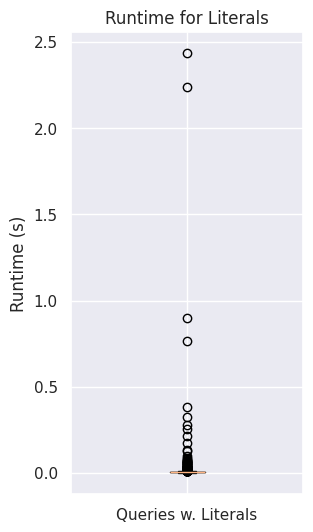

In [108]:
#fig = plt.figure(figsize =(3, 6))
fig, ax = plt.subplots(figsize=(3,6))
ax.boxplot(test_df_lits['mean_latency'])
ax.set_xticklabels(["Queries w. Literals"])
plt.title("Runtime for Literals")
plt.ylabel("Runtime (s)")
#plt.xlabel("Queries w. Literals")
plt.show()

In [112]:
test_df_lits[test_df_lits['time_cls'] != test_df_lits['planrgcn_prediction']]

,id_x,queryString,query_string_0,latency_0,resultset_0,query_string_1,latency_1,resultset_1,query_string_2,latency_2,...,Queries with 2 TP,Queries with more TP,S-P Concrete,P-O Concrete,S-O Concrete,fn,id2,id_y,time_cls,planrgcn_prediction
690,http://lsq.aksw.org/lsqQuery-QMZhk5RmBg2hFEx_r...,PREFIX xsd: <http://www.w3.org/2001/XMLSchema#...,PREFIX xsd: <http://www.w3.org/2001/XMLSchema#...,2.268005,NaN,PREFIX xsd: <http://www.w3.org/2001/XMLSchema#...,2.228335,NaN,PREFIX xsd: <http://www.w3.org/2001/XMLSchema#...,2.227775,...,1,0,0,0,0,/data/wikidata_0_1_10_v2_weight_loss/queryplan...,lsqQuery-QMZhk5RmBg2hFEx_rsxqBtVloPZb6nGNMoNJY...,lsqQuery-QMZhk5RmBg2hFEx_rsxqBtVloPZb6nGNMoNJY...,1,0
2999,http://lsq.aksw.org/additionalWikidata53733,SELECT ?var1 ?var2 ?var3 ?var4 ?var5 WHERE { ?...,SELECT ?var1 ?var2 ?var3 ?var4 ?var5 WHERE { ?...,7.309479,57786.0,SELECT ?var1 ?var2 ?var3 ?var4 ?var5 WHERE { ?...,0.000890,NaN,SELECT ?var1 ?var2 ?var3 ?var4 ?var5 WHERE { ?...,0.000855,...,0,1,0,1,0,/data/wikidata_0_1_10_v2_weight_loss/queryplan...,additionalWikidata53733,additionalWikidata53733,1,0


In [113]:
f1_score(test_df_lits['time_cls'], test_df_lits['planrgcn_prediction'], average=None)

array([0.99911972, 0.        ])

In [114]:
f1_score(test_df_lits['time_cls'], test_df_lits['planrgcn_prediction'], average='macro')

0.49955985915492956

In [116]:
test_df_lits['planrgcn_prediction'].unique(),test_df_lits['time_cls'].unique()

(array([0]), array([0, 1]))

In [124]:
test_wrongs = test_df[test_df['time_cls'] != test_df['planrgcn_prediction']]
test_wrongs

,id_x,queryString,query_string_0,latency_0,resultset_0,query_string_1,latency_1,resultset_1,query_string_2,latency_2,...,Queries with 2 TP,Queries with more TP,S-P Concrete,P-O Concrete,S-O Concrete,fn,id2,id_y,time_cls,planrgcn_prediction
7,http://lsq.aksw.org/lsqQuery-dtQgKlGIDCkMmNiwV...,PREFIX wdt: <http://www.wikidata.org/prop/dire...,PREFIX wdt: <http://www.wikidata.org/prop/dire...,45.169149,NaN,PREFIX wdt: <http://www.wikidata.org/prop/dire...,44.946615,NaN,PREFIX wdt: <http://www.wikidata.org/prop/dire...,44.793255,...,0,0,0,0,0,/data/wikidata_0_1_10_v2_weight_loss/queryplan...,lsqQuery-dtQgKlGIDCkMmNiwVVVuMHqgyjDlf3n9gd3dc...,lsqQuery-dtQgKlGIDCkMmNiwVVVuMHqgyjDlf3n9gd3dc...,2,0
15,http://lsq.aksw.org/lsqQuery-AK_ot2B0vFgFLYIVV...,PREFIX wde: <http://www.wikidata.org/entity/> ...,PREFIX wde: <http://www.wikidata.org/entity/> ...,4.623904,NaN,PREFIX wde: <http://www.wikidata.org/entity/> ...,4.435463,NaN,PREFIX wde: <http://www.wikidata.org/entity/> ...,4.381097,...,0,0,0,0,0,/data/wikidata_0_1_10_v2_weight_loss/queryplan...,lsqQuery-AK_ot2B0vFgFLYIVVM7d168PKNVkFHogKhy8P...,lsqQuery-AK_ot2B0vFgFLYIVVM7d168PKNVkFHogKhy8P...,1,0
41,http://lsq.aksw.org/827,SELECT * WHERE { ?x1 <http://www.wikidata.org/...,SELECT * WHERE { ?x1 <http://www.wikidata.org/...,81.187235,NaN,SELECT * WHERE { ?x1 <http://www.wikidata.org/...,81.315552,NaN,SELECT * WHERE { ?x1 <http://www.wikidata.org/...,82.450217,...,1,0,0,0,0,/data/wikidata_0_1_10_v2_weight_loss/queryplan...,827,827,2,0
67,http://lsq.aksw.org/lsqQuery-XdYbmbsd-DlNOwh34...,PREFIX xsd: <http://www.w3.org/2001/XMLSchema#...,PREFIX xsd: <http://www.w3.org/2001/XMLSchema#...,8.075740,NaN,PREFIX xsd: <http://www.w3.org/2001/XMLSchema#...,8.188409,NaN,PREFIX xsd: <http://www.w3.org/2001/XMLSchema#...,8.054463,...,0,0,0,0,0,/data/wikidata_0_1_10_v2_weight_loss/queryplan...,lsqQuery-XdYbmbsd-DlNOwh34KLETpQlY3Q3CYd9PO1dH...,lsqQuery-XdYbmbsd-DlNOwh34KLETpQlY3Q3CYd9PO1dH...,1,0
106,http://lsq.aksw.org/lsqQuery-sZGM735txptVo-Z9j...,PREFIX wde: <http://www.wikidata.org/entity/> ...,PREFIX wde: <http://www.wikidata.org/entity/> ...,1.087299,NaN,PREFIX wde: <http://www.wikidata.org/entity/> ...,1.109338,NaN,PREFIX wde: <http://www.wikidata.org/entity/> ...,1.092105,...,1,0,0,0,0,/data/wikidata_0_1_10_v2_weight_loss/queryplan...,lsqQuery-sZGM735txptVo-Z9jG_8S3XKkGoz_OUazepPc...,lsqQuery-sZGM735txptVo-Z9jG_8S3XKkGoz_OUazepPc...,1,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4007,http://lsq.aksw.org/1157,SELECT * WHERE { ?x1 <http://www.wikidata.org/...,SELECT * WHERE { ?x1 <http://www.wikidata.org/...,84.635415,NaN,SELECT * WHERE { ?x1 <http://www.wikidata.org/...,85.901238,NaN,SELECT * WHERE { ?x1 <http://www.wikidata.org/...,85.152448,...,0,1,0,0,0,/data/wikidata_0_1_10_v2_weight_loss/queryplan...,1157,1157,2,0
4027,http://lsq.aksw.org/lsqQuery-DC1VhZ3cjMGU-hywl...,PREFIX wde: <http://www.wikidata.org/entity/> ...,PREFIX wde: <http://www.wikidata.org/entity/> ...,4.652143,NaN,PREFIX wde: <http://www.wikidata.org/entity/> ...,4.654881,NaN,PREFIX wde: <http://www.wikidata.org/entity/> ...,4.770466,...,1,0,0,0,0,/data/wikidata_0_1_10_v2_weight_loss/queryplan...,lsqQuery-DC1VhZ3cjMGU-hywlVHjUpDSM28M4cqvTfOdh...,lsqQuery-DC1VhZ3cjMGU-hywlVHjUpDSM28M4cqvTfOdh...,1,0
4037,http://lsq.aksw.org/616,SELECT * WHERE { ?x1 <http://www.wikidata.org/...,SELECT * WHERE { ?x1 <http://www.wikidata.org/...,115.941031,NaN,SELECT * WHERE { ?x1 <http://www.wikidata.org/...,116.488546,NaN,SELECT * WHERE { ?x1 <http://www.wikidata.org/...,116.317004,...,0,1,0,1,0,/data/wikidata_0_1_10_v2_weight_loss/queryplan...,616,616,2,0
4044,http://lsq.aksw.org/1196,SELECT * WHERE { ?x1 <http://www.wikidata.org/...,SELECT * WHERE { ?x1 <http://www.wikidata.org/...,158.453636,NaN,SELECT * WHERE { ?x1 <http://www.wikidata.org/...,158.114839,NaN,SELECT * WHERE { ?x1 <http://www.wikidata.org/...,157.922055,...,0,1,0,0,0,/data/wikidata_0_1_10_v2_weight_loss/queryplan...,1196,1196,2,0


In [128]:
test_wrongs[test_wrongs['time_cls'] == 2]

,id_x,queryString,query_string_0,latency_0,resultset_0,query_string_1,latency_1,resultset_1,query_string_2,latency_2,...,Queries with 2 TP,Queries with more TP,S-P Concrete,P-O Concrete,S-O Concrete,fn,id2,id_y,time_cls,planrgcn_prediction
7,http://lsq.aksw.org/lsqQuery-dtQgKlGIDCkMmNiwV...,PREFIX wdt: <http://www.wikidata.org/prop/dire...,PREFIX wdt: <http://www.wikidata.org/prop/dire...,45.169149,NaN,PREFIX wdt: <http://www.wikidata.org/prop/dire...,44.946615,NaN,PREFIX wdt: <http://www.wikidata.org/prop/dire...,44.793255,...,0,0,0,0,0,/data/wikidata_0_1_10_v2_weight_loss/queryplan...,lsqQuery-dtQgKlGIDCkMmNiwVVVuMHqgyjDlf3n9gd3dc...,lsqQuery-dtQgKlGIDCkMmNiwVVVuMHqgyjDlf3n9gd3dc...,2,0
41,http://lsq.aksw.org/827,SELECT * WHERE { ?x1 <http://www.wikidata.org/...,SELECT * WHERE { ?x1 <http://www.wikidata.org/...,81.187235,NaN,SELECT * WHERE { ?x1 <http://www.wikidata.org/...,81.315552,NaN,SELECT * WHERE { ?x1 <http://www.wikidata.org/...,82.450217,...,1,0,0,0,0,/data/wikidata_0_1_10_v2_weight_loss/queryplan...,827,827,2,0
151,http://lsq.aksw.org/649,SELECT * WHERE { ?x1 <http://www.wikidata.org/...,SELECT * WHERE { ?x1 <http://www.wikidata.org/...,154.573544,NaN,SELECT * WHERE { ?x1 <http://www.wikidata.org/...,154.500773,NaN,SELECT * WHERE { ?x1 <http://www.wikidata.org/...,154.581120,...,1,0,0,0,0,/data/wikidata_0_1_10_v2_weight_loss/queryplan...,649,649,2,0
204,http://lsq.aksw.org/472,SELECT * WHERE { ?x1 <http://www.wikidata.org/...,SELECT * WHERE { ?x1 <http://www.wikidata.org/...,113.998259,NaN,SELECT * WHERE { ?x1 <http://www.wikidata.org/...,116.993821,NaN,SELECT * WHERE { ?x1 <http://www.wikidata.org/...,115.392552,...,0,1,0,1,0,/data/wikidata_0_1_10_v2_weight_loss/queryplan...,472,472,2,0
415,http://lsq.aksw.org/1360,SELECT * WHERE { ?x1 <http://www.wikidata.org/...,SELECT * WHERE { ?x1 <http://www.wikidata.org/...,83.179454,NaN,SELECT * WHERE { ?x1 <http://www.wikidata.org/...,82.560329,NaN,SELECT * WHERE { ?x1 <http://www.wikidata.org/...,83.501577,...,0,1,0,0,0,/data/wikidata_0_1_10_v2_weight_loss/queryplan...,1360,1360,2,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3942,http://lsq.aksw.org/1219,SELECT * WHERE { ?x1 <http://www.wikidata.org/...,SELECT * WHERE { ?x1 <http://www.wikidata.org/...,78.707844,NaN,SELECT * WHERE { ?x1 <http://www.wikidata.org/...,79.371419,NaN,SELECT * WHERE { ?x1 <http://www.wikidata.org/...,79.660040,...,1,0,0,0,0,/data/wikidata_0_1_10_v2_weight_loss/queryplan...,1219,1219,2,0
3946,http://lsq.aksw.org/lsqQuery-0dYMkMBi-q4cfbn7E...,PREFIX wde: <http://www.wikidata.org/entity/> ...,PREFIX wde: <http://www.wikidata.org/entity/> ...,89.677761,NaN,PREFIX wde: <http://www.wikidata.org/entity/> ...,90.063996,NaN,PREFIX wde: <http://www.wikidata.org/entity/> ...,88.848272,...,0,1,0,1,0,/data/wikidata_0_1_10_v2_weight_loss/queryplan...,lsqQuery-0dYMkMBi-q4cfbn7EvTDZH0d8LotENiFq_Esb...,lsqQuery-0dYMkMBi-q4cfbn7EvTDZH0d8LotENiFq_Esb...,2,0
4007,http://lsq.aksw.org/1157,SELECT * WHERE { ?x1 <http://www.wikidata.org/...,SELECT * WHERE { ?x1 <http://www.wikidata.org/...,84.635415,NaN,SELECT * WHERE { ?x1 <http://www.wikidata.org/...,85.901238,NaN,SELECT * WHERE { ?x1 <http://www.wikidata.org/...,85.152448,...,0,1,0,0,0,/data/wikidata_0_1_10_v2_weight_loss/queryplan...,1157,1157,2,0
4037,http://lsq.aksw.org/616,SELECT * WHERE { ?x1 <http://www.wikidata.org/...,SELECT * WHERE { ?x1 <http://www.wikidata.org/...,115.941031,NaN,SELECT * WHERE { ?x1 <http://www.wikidata.org/...,116.488546,NaN,SELECT * WHERE { ?x1 <http://www.wikidata.org/...,116.317004,...,0,1,0,1,0,/data/wikidata_0_1_10_v2_weight_loss/queryplan...,616,616,2,0


In [149]:
class UnboundTripleExtractor(DefaultVisitor):
    def __init__(self):
        self.containsUnboundTrp = False
        
    def visitTriple(self,input):
        bool = True
        for x in [input['Object']['value'],input['Subject'],input['Predicate']]:
            #for checking amount of blank nodes
            #if ( x.startswith(':') or  x.startswith('_:')):
            #    print('here')
            #    bool = True
            if not (x.startswith('?') or x.startswith(':') or x.startswith('$') or x.startswith('_:')):
                bool = False
        if bool:
            self.containsUnboundTrp = True
                
            
def contains_unbound_triple(x):
    visitor = UnboundTripleExtractor()
    try:
        qp = json.load(open(x, "r"))
    except Exception:
        try:
            qp = json5.load(open(x,'r'))
        except:
            return False
    dispatch(qp, visitor)
    return visitor.containsUnboundTrp
    
test_df_unbound = test_df[test_df['fn'].apply(contains_unbound_triple)]
test_df_unbound

,id_x,queryString,query_string_0,latency_0,resultset_0,query_string_1,latency_1,resultset_1,query_string_2,latency_2,...,Queries with 2 TP,Queries with more TP,S-P Concrete,P-O Concrete,S-O Concrete,fn,id2,id_y,time_cls,planrgcn_prediction
4,http://lsq.aksw.org/lsqQuery-YfROTDJ46bHz8EuH1...,PREFIX xsd: <http://www.w3.org/2001/XMLSchema#...,PREFIX xsd: <http://www.w3.org/2001/XMLSchema#...,28.555774,NaN,PREFIX xsd: <http://www.w3.org/2001/XMLSchema#...,28.588427,NaN,PREFIX xsd: <http://www.w3.org/2001/XMLSchema#...,29.520475,...,1,0,0,0,0,/data/wikidata_0_1_10_v2_weight_loss/queryplan...,lsqQuery-YfROTDJ46bHz8EuH1m0rTZZY3PNVtxn00yxjJ...,lsqQuery-YfROTDJ46bHz8EuH1m0rTZZY3PNVtxn00yxjJ...,2,2
13,http://lsq.aksw.org/lsqQuery-DPGw80qQzywWyAM1q...,PREFIX xsd: <http://www.w3.org/2001/XMLSchema#...,PREFIX xsd: <http://www.w3.org/2001/XMLSchema#...,0.016548,NaN,PREFIX xsd: <http://www.w3.org/2001/XMLSchema#...,0.003099,NaN,PREFIX xsd: <http://www.w3.org/2001/XMLSchema#...,0.002627,...,0,1,0,0,0,/data/wikidata_0_1_10_v2_weight_loss/queryplan...,lsqQuery-DPGw80qQzywWyAM1qJhuoMtcPLqin7eNHGKVd...,lsqQuery-DPGw80qQzywWyAM1qJhuoMtcPLqin7eNHGKVd...,0,0
68,http://lsq.aksw.org/lsqQuery-MswX31r3ky5RjdWvb...,PREFIX wde: <http://www.wikidata.org/entity/> ...,PREFIX wde: <http://www.wikidata.org/entity/> ...,0.004739,NaN,PREFIX wde: <http://www.wikidata.org/entity/> ...,0.002970,NaN,PREFIX wde: <http://www.wikidata.org/entity/> ...,0.002986,...,0,1,0,0,0,/data/wikidata_0_1_10_v2_weight_loss/queryplan...,lsqQuery-MswX31r3ky5RjdWvbIhU57KtxMJQ3Rf0tKPQ0...,lsqQuery-MswX31r3ky5RjdWvbIhU57KtxMJQ3Rf0tKPQ0...,0,0
84,http://lsq.aksw.org/lsqQuery-bGPUfkyi4AN8JiJrW...,PREFIX rdf: <http://www.w3.org/1999/02/22-rdf-...,PREFIX rdf: <http://www.w3.org/1999/02/22-rdf-...,0.006042,NaN,PREFIX rdf: <http://www.w3.org/1999/02/22-rdf-...,0.005293,NaN,PREFIX rdf: <http://www.w3.org/1999/02/22-rdf-...,0.003190,...,0,1,0,0,0,/data/wikidata_0_1_10_v2_weight_loss/queryplan...,lsqQuery-bGPUfkyi4AN8JiJrWp8fMCBxRpvs46Kp-uZRM...,lsqQuery-bGPUfkyi4AN8JiJrWp8fMCBxRpvs46Kp-uZRM...,0,0
90,http://lsq.aksw.org/lsqQuery-QD94PRmK7UYztk6AU...,PREFIX rdf: <http://www.w3.org/1999/02/22-rdf-...,PREFIX rdf: <http://www.w3.org/1999/02/22-rdf-...,0.006090,NaN,PREFIX rdf: <http://www.w3.org/1999/02/22-rdf-...,0.003081,NaN,PREFIX rdf: <http://www.w3.org/1999/02/22-rdf-...,0.002608,...,0,1,0,0,0,/data/wikidata_0_1_10_v2_weight_loss/queryplan...,lsqQuery-QD94PRmK7UYztk6AUTNFEcWLyiBMAFORQoerF...,lsqQuery-QD94PRmK7UYztk6AUTNFEcWLyiBMAFORQoerF...,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3958,http://lsq.aksw.org/additionalWikidata121073,SELECT( COUNT ( ?var1 && ?var2 && ?var3 ) AS ?...,SELECT( COUNT ( ?var1 && ?var2 && ?var3 ) AS ?...,0.000377,NaN,SELECT( COUNT ( ?var1 && ?var2 && ?var3 ) AS ?...,0.000386,NaN,SELECT( COUNT ( ?var1 && ?var2 && ?var3 ) AS ?...,0.000377,...,1,0,0,0,0,/data/wikidata_0_1_10_v2_weight_loss/queryplan...,additionalWikidata121073,additionalWikidata121073,0,2
4008,http://lsq.aksw.org/additionalWikidata8297,SELECT DISTINCT ?var1 WHERE { ?var2 ?var1 ?var...,SELECT DISTINCT ?var1 WHERE { ?var2 ?var1 ?var...,0.002400,0.0,SELECT DISTINCT ?var1 WHERE { ?var2 ?var1 ?var...,0.003057,0.0,SELECT DISTINCT ?var1 WHERE { ?var2 ?var1 ?var...,0.003143,...,1,0,0,0,0,/data/wikidata_0_1_10_v2_weight_loss/queryplan...,additionalWikidata8297,additionalWikidata8297,0,0
4016,http://lsq.aksw.org/additionalWikidata1176,SELECT DISTINCT ?var1 WHERE { ?var2 ?var3 ?var...,SELECT DISTINCT ?var1 WHERE { ?var2 ?var3 ?var...,0.003530,0.0,SELECT DISTINCT ?var1 WHERE { ?var2 ?var3 ?var...,0.004315,0.0,SELECT DISTINCT ?var1 WHERE { ?var2 ?var3 ?var...,0.002725,...,1,0,0,0,0,/data/wikidata_0_1_10_v2_weight_loss/queryplan...,additionalWikidata1176,additionalWikidata1176,0,0
4029,http://lsq.aksw.org/lsqQuery-cxajbjUWmaBGC0kCa...,PREFIX wde: <http://www.wikidata.org/entity/> ...,PREFIX wde: <http://www.wikidata.org/entity/> ...,0.003870,NaN,PREFIX wde: <http://www.w

In [151]:
test_df_unbound.iloc[1]['queryString']

'PREFIX xsd: <http://www.w3.org/2001/XMLSchema#> PREFIX wde: <http://www.wikidata.org/entity/> PREFIX rdfs: <http://www.w3.org/2000/01/rdf-schema#> PREFIX wikibase: <http://wikiba.se/ontology#> SELECT ?var1 ?var2 ?var3 ?var4Label ?var5 ?var6 ?var4 WHERE { wde:Q9197118 ?var4 ?var6 . ?var5 wikibase:directClaim ?var4 ; rdfs:label ?var4Label ; ?var3 ?var2 . ?var1 wikibase:directClaim ?var3 FILTER ( ( "en" = lang(?var6) ) || ( "" = lang(?var6) ) ) FILTER ( "en" = lang(?var4Label) ) } '

In [153]:
f1_score(test_df_unbound['time_cls'], test_df_unbound['planrgcn_prediction'], average=None),f1_score(test_df_unbound['time_cls'], test_df_unbound['planrgcn_prediction'], average='macro')

(array([0.95535714, 0.6       , 0.63636364]), 0.7305735930735932)